

```
# 1. Preparation of the enviromental.

```



In [1]:
%pip install tensorflow tensorflow-hub tensorflow-datasets matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install Dependences
!pip install torch torchvision
!pip install opencv-python-headless
!pip install pascal-voc-writer # Install Right Dataset

import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.patches as patches
import cv2
from PIL import Image
import requests
from io import BytesIO

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

2024-12-02 21:45:23.588926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 21:45:23.609910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 21:45:23.616082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 21:45:23.632021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 21:45:24.579300: W tensorflow/comp

TensorFlow version: 2.17.0
TensorFlow Hub version: 0.16.1


2. Download and processing DataSet



In [3]:
# Load a smaller dataset
def load_data(split='train'):
    dataset, info = tfds.load('voc/2007', split=split, shuffle_files=True, with_info=True)
    return dataset, info

# Load the train dataset and extract info
train_dataset, train_info = load_data('train[:10%]')

# Load the validation dataset
validation_dataset, validation_info = load_data('validation[:10%]')

# Get class names
class_names = train_info.features["objects"]["label"].names 
print("Midterm Class:", class_names)

Midterm Class: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


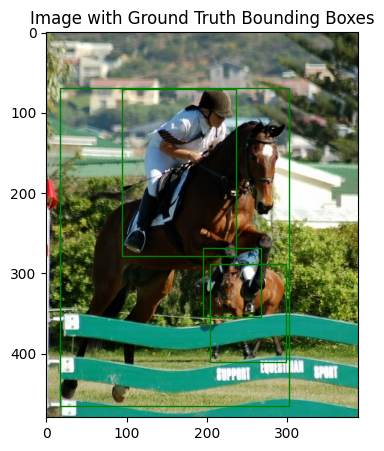

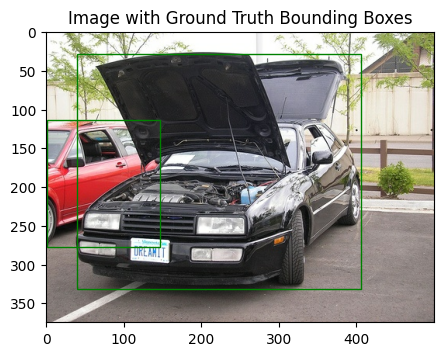

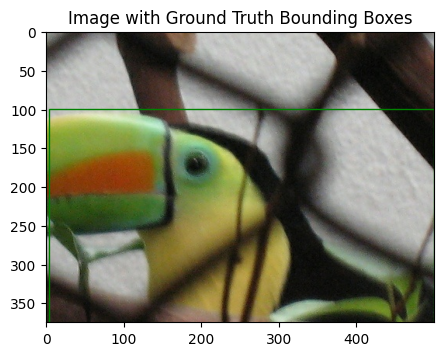

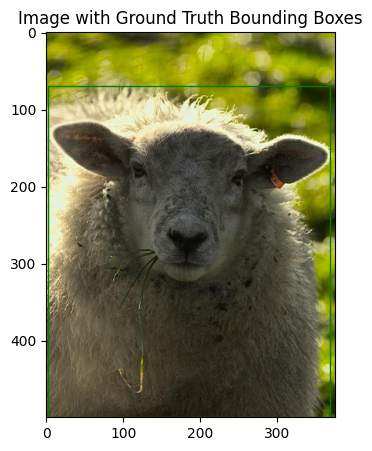

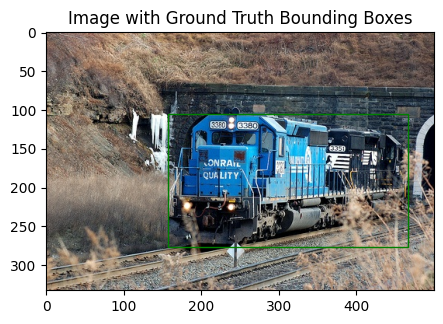

2024-12-02 21:45:27.544847: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
def display_examples(dataset, n=5):  # Display 'n' examples by default
    for example in dataset.take(n):
        image = example["image"]
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title("Image with Ground Truth Bounding Boxes")

        # Draw ground truth boxes
        for box in example["objects"]["bbox"]:
            ymin, xmin, ymax, xmax = box
            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='g', facecolor='none')
            plt.gca().add_patch(rect)

        plt.show()

display_examples(train_dataset)

In [11]:
#Remove irrelevant or low-quality images

import tensorflow as tf
import tensorflow_datasets as tfds

# Load datasets
def load_data(split='train'):
    dataset, info = tfds.load('voc/2007', split=split, shuffle_files=True, with_info=True)
    return dataset, info

train_dataset, train_info = load_data('train[:10%]')
validation_dataset, validation_info = load_data('validation[:10%]')

# Filter functions
def filter_images_with_bboxes(dataset):
    def has_objects(example):
        return tf.size(example['objects']['label']) > 0
    return dataset.filter(has_objects)

def filter_valid_bboxes(dataset):
    def has_valid_bboxes(example):
        bbox = example['objects']['bbox']
        ymin, xmin, ymax, xmax = tf.split(bbox, num_or_size_splits=4, axis=1)
        valid_bboxes = tf.reduce_any((ymax - ymin) > 0) & tf.reduce_any((xmax - xmin) > 0)
        return valid_bboxes
    return dataset.filter(has_valid_bboxes)

# Apply cleaning
filtered_train_dataset = filter_images_with_bboxes(train_dataset)
filtered_train_dataset = filter_valid_bboxes(filtered_train_dataset)

filtered_validation_dataset = filter_images_with_bboxes(validation_dataset)
filtered_validation_dataset = filter_valid_bboxes(filtered_validation_dataset)

# Validate cleaning process
def count_examples(dataset):
    return sum(1 for _ in dataset)

original_train_count = count_examples(train_dataset)
original_validation_count = count_examples(validation_dataset)
cleaned_train_count = count_examples(filtered_train_dataset)
print(f"Filtered train count: {cleaned_train_count}")
cleaned_validation_count = count_examples(filtered_validation_dataset)

print(f"Original train count: {original_train_count}, Cleaned train count: {cleaned_train_count}")
print(f"Original validation count: {original_validation_count}, Cleaned validation count: {cleaned_validation_count}")

# Example of safe iteration
num_epochs=7

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for example in filtered_train_dataset:
        # Process each example
        pass



2024-12-02 21:47:28.048050: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Filtered train count: 250
Original train count: 250, Cleaned train count: 250
Original validation count: 251, Cleaned validation count: 251
Epoch 1/7
Epoch 2/7
Epoch 3/7
Epoch 4/7
Epoch 5/7
Epoch 6/7
Epoch 7/7


In [6]:
#Normalize image size

# Function to resize and normalize images
def preprocess_images(example, target_size=(224, 224)):
    image = example['image']
    image = tf.image.resize(image, target_size)  # Resize to target size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    
    # Update the example with resized and normalized image
    example['image'] = image
    return example

# Apply preprocessing to datasets
resized_train_dataset = filtered_train_dataset.map(lambda x: preprocess_images(x))
resized_validation_dataset = filtered_validation_dataset.map(lambda x: preprocess_images(x))

# Check the shape of a few images after resizing
for example in resized_train_dataset.take(5):
    print(f"Image shape: {example['image'].shape}")

# Set the batch size
batch_size = 32

# Batch the datasets
batched_train_dataset = resized_train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
batched_validation_dataset = resized_validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


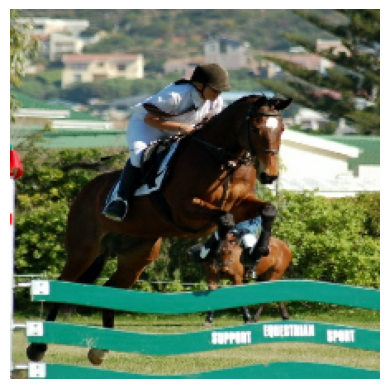

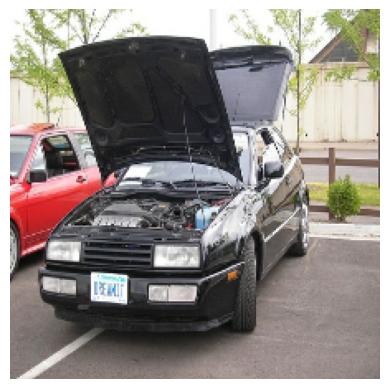

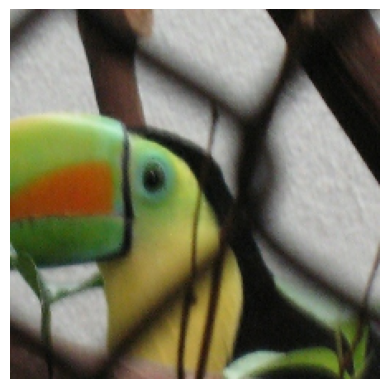

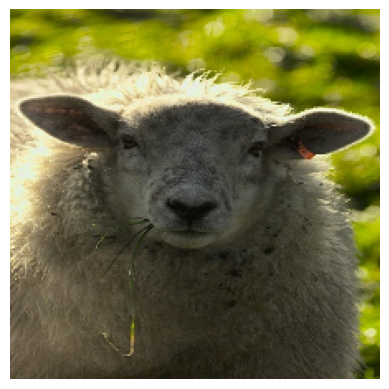

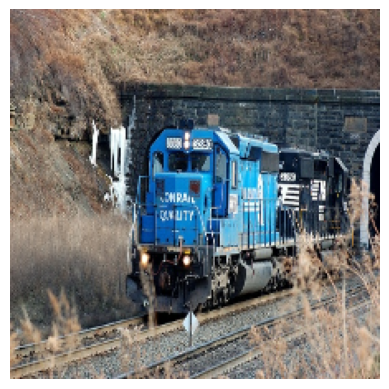

In [7]:
# Function to display an image after resizing
def display_image(example):
    image = example['image']
    
    # Convert the image tensor to a NumPy array
    image = np.array(image)
    
    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Take a single example from the dataset
for example in resized_train_dataset.take(5):
    display_image(example)

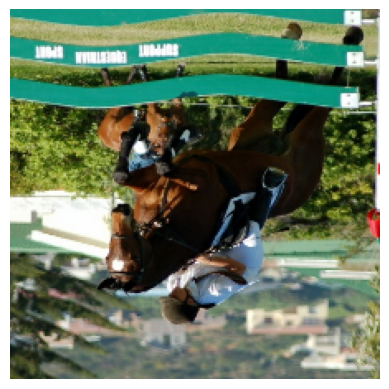

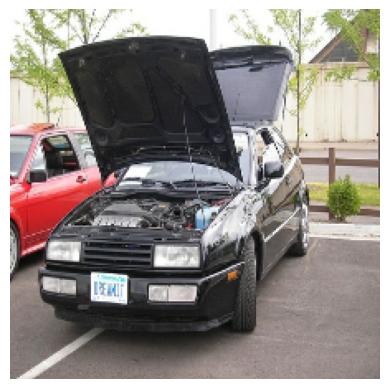

In [10]:
#Data Augmentation

# Function to apply horizontal and vertical flipping to an image
def augment_flips(image):
    # Apply random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Apply random vertical flip
    image = tf.image.random_flip_up_down(image)
    return image

# Function to display image
def display_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Example: Get an image from the dataset and apply flips
for example in resized_train_dataset.take(2):  # Take one image from the dataset
    image = example['image']
    
    # Apply flipping augmentation
    flipped_image = augment_flips(image)
    
    # Convert the flipped image to a numpy array and display
    flipped_image = flipped_image.numpy()
    display_image(flipped_image)


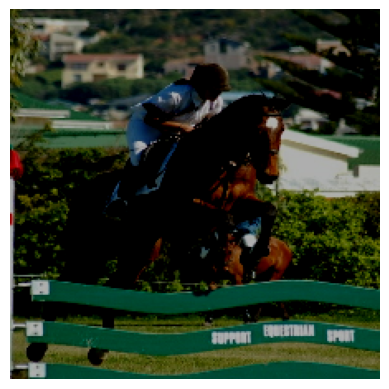

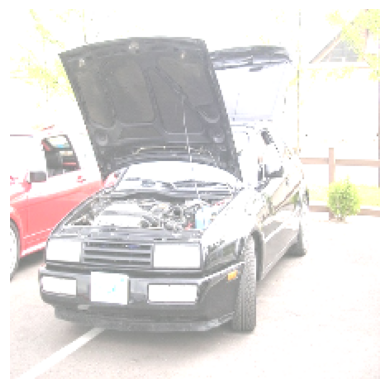

In [19]:
#Brightness Adjustment
def augment_brightness(image, max_delta=0.49):
    image = tf.image.random_brightness(image, max_delta=max_delta)  # Random brightness change
    return image

# Function to display image
def display_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Example: Get an image from the dataset and apply brightness adjustment
for example in resized_train_dataset.take(2):  # Take two images from the dataset
    image = example['image']
    
    # Apply brightness adjustment using the correct function
    brightness_adjusted_image = augment_brightness(image)  # Use augment_brightness here
    display_image(brightness_adjusted_image.numpy())  # Display brightness adjusted image